# Baseline

## Klasyfikacja binarna mowy nienawiści (toxic vs non-toxic)

**Baseline:** TF-IDF (uni+bi) → Regresja logistyczna / Linear SVM

**Metryki:** Accuracy, Macro F1, ROC-AUC + macierz pomyłek

In [54]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

SEED = 42

df_train = pd.read_csv("../data/df_train.csv", index_col="id")
df_val = pd.read_csv("../data/df_val.csv", index_col="id")
df_test = pd.read_csv("../data/df_test.csv", index_col="id")

In [55]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

train_vectorized = vectorizer.fit_transform(df_train["comment_text"])
val_vectorized = vectorizer.transform(df_val["comment_text"])
test_vectorized = vectorizer.transform(df_test["comment_text"])

In [56]:
svc = LinearSVC(random_state=SEED)

train_labels = np.char.add(df_train["toxic"].astype("string"), df_train["severe_toxic"].astype("string"))
val_labels = np.char.add(df_val["toxic"].astype("string"), df_val["severe_toxic"].astype("string"))

svc.fit(X=train_vectorized, y=train_labels)
val_labels_prd = svc.predict(val_vectorized)

labels = ["00", "01", "10", "11"]
label_names = ["not toxic, not severe toxic", "not toxic, severe toxic", "toxic, not severe toxic", "toxic, severe toxic"]
conf = confusion_matrix(val_labels, val_labels_prd, labels=labels)
conf_frame = pd.DataFrame(conf, columns=np.char.add("(P) ", label_names), index=np.char.add("(T) ", label_names))

conf_frame

# TODO: policzyć na tym accuracy, macro-f1 i roc-auc

,"(P) not toxic, not severe toxic","(P) not toxic, severe toxic","(P) toxic, not severe toxic","(P) toxic, severe toxic"
"(T) not toxic, not severe toxic",1806,0,7,0
"(T) not toxic, severe toxic",0,0,0,0
"(T) toxic, not severe toxic",79,0,77,2
"(T) toxic, severe toxic",6,0,22,1


In [57]:
# Imports i konfiguracja
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

SEED = 42
np.random.seed(SEED)

# Wszystkie dostępne etykiety w datasecie
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
TEXT_COL = "comment_text"
ID_COL = "id"

In [58]:
# Wczytanie danych
train_path = "../data/df_train.csv"
val_path = "../data/df_val.csv"
test_path = "../data/raw/test.csv"
test_labels_path = "../data/raw/test_labels.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

# Test: merge tekstu i etykiet, odfiltruj -1 (brak etykiety)
df_test_text = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test = df_test_text.merge(df_test_labels, on=ID_COL, how="inner")
mask_valid = (df_test[LABELS] >= 0).all(axis=1)
df_test = df_test.loc[mask_valid].reset_index(drop=True)

# Przekształć na klasyfikację binarną: toxic vs non-toxic
# Etykieta = 1 jeśli którakolwiek z 6 etykiet == 1
for df in (df_train, df_val, df_test):
    df[TEXT_COL] = df[TEXT_COL].fillna("")
    df["is_toxic"] = df[LABELS].max(axis=1)

print("Shapes:")
print(f"  train: {df_train.shape} | toxic: {df_train['is_toxic'].sum()} ({df_train['is_toxic'].mean():.1%})")
print(f"  val:   {df_val.shape} | toxic: {df_val['is_toxic'].sum()} ({df_val['is_toxic'].mean():.1%})")
print(f"  test:  {df_test.shape} | toxic: {df_test['is_toxic'].sum()} ({df_test['is_toxic'].mean():.1%})")

# Check wycieku ID
ids_train, ids_val, ids_test = set(df_train[ID_COL]), set(df_val[ID_COL]), set(df_test[ID_COL])
print(f"\nID Intersections: train∩val={len(ids_train & ids_val)}, train∩test={len(ids_train & ids_test)}, val∩test={len(ids_val & ids_test)}")

Shapes:
  train: (20000, 9) | toxic: 1997 (10.0%)
  val:   (2000, 9) | toxic: 198 (9.9%)
  test:  (63978, 9) | toxic: 6243 (9.8%)

ID Intersections: train∩val=0, train∩test=0, val∩test=0


In [59]:
# Definicja modelu baseline
CLASSIFIER = "logreg"  # "logreg" | "linear_svc"

tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1, 2),
    min_df=2,
    max_features=200_000,
)

if CLASSIFIER == "logreg":
    clf = LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        C=2.0,
        max_iter=400,
    )
elif CLASSIFIER == "linear_svc":
    clf = LinearSVC(
        class_weight="balanced",
        C=2.0,
        max_iter=2000,
    )
else:
    raise ValueError("Unknown CLASSIFIER")

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

In [60]:
# Trenowanie na zbiorze treningowym
X_train = df_train[TEXT_COL]
y_train = df_train["is_toxic"].values
X_val = df_val[TEXT_COL]
y_val = df_val["is_toxic"].values
X_test = df_test[TEXT_COL]
y_test = df_test["is_toxic"].values

pipe.fit(X_train, y_train)
print("Model trained on", len(X_train), "samples")

Model trained on 20000 samples


In [61]:
# Ewaluacja na walidacji
y_val_pred = pipe.predict(X_val)
y_val_prob = pipe.predict_proba(X_val)[:, 1]  # P(toxic)

val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average="macro")
val_auc = roc_auc_score(y_val, y_val_prob)

print(classification_report(y_val, y_val_pred, target_names=["non-toxic", "toxic"], digits=4))
print(f"Accuracy:  {val_acc:.4f}")
print(f"Macro F1:  {val_f1:.4f}")
print(f"ROC-AUC:   {val_auc:.4f}")

              precision    recall  f1-score   support

   non-toxic     0.9714    0.9623    0.9668      1802
       toxic     0.6837    0.7424    0.7119       198

    accuracy                         0.9405      2000
   macro avg     0.8276    0.8523    0.8393      2000
weighted avg     0.9429    0.9405    0.9416      2000

Accuracy:  0.9405
Macro F1:  0.8393
ROC-AUC:   0.9415


In [62]:
# Ewaluacja na teście
y_test_pred = pipe.predict(X_test)
y_test_prob = pipe.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")
test_auc = roc_auc_score(y_test, y_test_prob)

print(classification_report(y_test, y_test_pred, target_names=["non-toxic", "toxic"], digits=4))
print(f"Accuracy:  {test_acc:.4f}")
print(f"Macro F1:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

              precision    recall  f1-score   support

   non-toxic     0.9727    0.9240    0.9477     57735
       toxic     0.5195    0.7599    0.6171      6243

    accuracy                         0.9080     63978
   macro avg     0.7461    0.8420    0.7824     63978
weighted avg     0.9285    0.9080    0.9155     63978

Accuracy:  0.9080
Macro F1:  0.7824
ROC-AUC:   0.9388


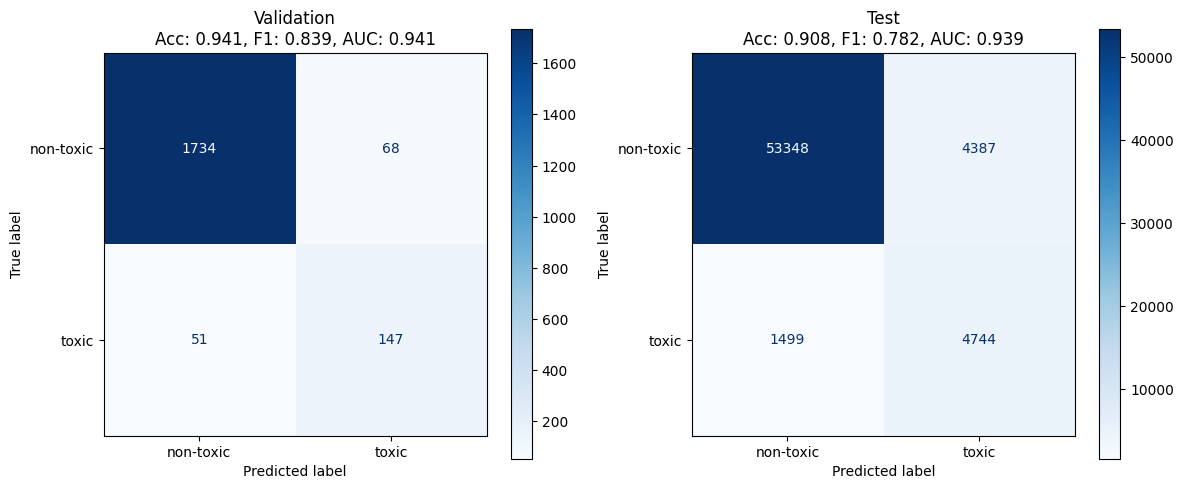

In [63]:
# Macierze pomyłek
import pathlib
reports_dir = pathlib.Path("../reports")
reports_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# VAL
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(cm_val, display_labels=["non-toxic", "toxic"])
disp_val.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Validation\nAcc: {val_acc:.3f}, F1: {val_f1:.3f}, AUC: {val_auc:.3f}")

# TEST
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=["non-toxic", "toxic"])
disp_test.plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title(f"Test\nAcc: {test_acc:.3f}, F1: {test_f1:.3f}, AUC: {test_auc:.3f}")

plt.tight_layout()
plt.savefig(reports_dir / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

In [64]:
# Zapisz metryki do JSON
metrics = {
    "task": "binary_classification",
    "dataset": "Jigsaw Toxic Comment (Wikipedia)",
    "model": {
        "type": CLASSIFIER,
        "classifier": str(clf.__class__.__name__),
        "C": getattr(clf, "C", None),
        "class_weight": getattr(clf, "class_weight", None),
    },
    "vectorizer": {
        "type": "TF-IDF",
        "ngram_range": list(tfidf.ngram_range),
        "max_features": tfidf.max_features,
        "min_df": tfidf.min_df,
    },
    "val": {
        "accuracy": float(val_acc),
        "macro_f1": float(val_f1),
        "roc_auc": float(val_auc),
    },
    "test": {
        "accuracy": float(test_acc),
        "macro_f1": float(test_f1),
        "roc_auc": float(test_auc),
    },
}

with open(reports_dir / "metrics_baseline.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print(f"  Val  - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
print(f"  Test - Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

  Val  - Acc: 0.9405, F1: 0.8393, AUC: 0.9415
  Test - Acc: 0.9080, F1: 0.7824, AUC: 0.9388


In [65]:
# Porównanie modeli: LogReg vs LinearSVC (z różnymi C)
from sklearn.base import clone

def eval_model(model_name, clf, X_train, y_train, X_val, y_val):
    vec = TfidfVectorizer(lowercase=True, strip_accents="unicode", ngram_range=(1,2), min_df=2, max_features=200_000)
    pipe = Pipeline([("tfidf", vec), ("clf", clone(clf))])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_val)
    y_prob = pipe.predict_proba(X_val)[:, 1]
    
    return {
        "model": model_name,
        "accuracy": accuracy_score(y_val, y_pred),
        "macro_f1": f1_score(y_val, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y_val, y_prob),
    }

results = []
for model_name, base, Cs in [
    ("LogReg", LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=400), [0.5, 1.0, 2.0]),
    ("LinearSVC", LinearSVC(class_weight="balanced", max_iter=2000), [0.5, 1.0, 2.0]),
]:
    for C in Cs:
        clf_test = clone(base)
        clf_test.C = C
        res = eval_model(f"{model_name} C={C}", clf_test, X_train, y_train, X_val, y_val)
        results.append(res)

df_comparison = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
print("Model Comparison (sorted by Macro F1):")
df_comparison

AttributeError: This 'Pipeline' has no attribute 'predict_proba'